In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Project/')

# Imports

In [ ]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 8.5 MB/s 


In [ ]:
from functions import *
from gensim import corpora, models, similarities
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from spacy.lang.ru import Russian
from tqdm import tqdm
from torchvision import transforms


import collections
import copy
import gensim
import lightgbm as lgb
import math
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sn
import spacy
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost

# Preprocessing Data

База данных состоит из 12 столбцов:

– id: уникальный номер сообщения в системе twitter;

– tdate: дата публикации сообщения (твита);

– tnamee: имя пользователя, опубликовавшего сообщение;

– ttext:  текст сообщения (твита);

– ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);

– trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;

– trtw: число ретвитов;

– tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;

– tstcount: число всех сообщений пользователя в сети twitter;

– tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);

– tfrien: количество друзей пользователя (те люди, которых читает пользователь);

– listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

Прочитаем данные и построим различные статистики.

In [ ]:
positive_path = "/content/gdrive/MyDrive/Project/positive.csv"
negative_path = "/content/gdrive/MyDrive/Project/negative.csv"

In [ ]:
columns_name = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep','trtw', 'tfav',
                'tstcount', 'tfol', 'tfrien', 'listcount']
positive_dataset = pd.read_csv(positive_path, sep = ';', names = columns_name)
negative_dataset = pd.read_csv(negative_path, sep = ';', names = columns_name)

In [ ]:
len(positive_dataset)

114911

In [ ]:
positive_dataset.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Тренировочный корпус состоит из 114,911 положительных, 111,923 отрицательных записей.

Удалим NA.

In [ ]:
pos_text = positive_dataset['ttext'].dropna().values
neg_text = negative_dataset['ttext'].dropna().values

In [ ]:
from typing import List

In [ ]:
# отделим от слов смайлики и запишем их как один
def split_smile(reg_exp: str, smile: str, sentences: List[str]) -> List[str]:
  return [re.sub(reg_exp, smile, sentence) for sentence in sentences]

In [ ]:
pos_text = regul(r' *http\S* *', pos_text)
pos_text = regul(r' *@\S* ', pos_text)
pos_text = regul(r'RT *', pos_text)
pos_text = regul(r'&quot;', pos_text)
pos_text = regul(r'\n', pos_text)
pos_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', pos_text)
pos_text = split_smile(r'(\w)([:;/\!]*)\)+', r'\1 \2)', pos_text)
# pos_text = split_smile(r'(\w)\)+', r'\1 )', pos_text)

In [ ]:
pos_text[10]

'Люблю маму и папу а в остальное я так -влюбляюсь  привязываюсь )\xa0'

In [ ]:
neg_text = regul(r' *http\S* *', neg_text)
neg_text = regul(r' *@\S* ', neg_text)
neg_text = regul(r'RT *', neg_text)
neg_text = regul(r'&quot;', neg_text)
neg_text = regul(r'\n', neg_text)
neg_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', neg_text)
neg_text = split_smile(r'(\w)([:/\!]*)\(+', r'\1 \2(', neg_text)
# neg_text = split_smile(r'(\w)\(+', r'\1 (', neg_text)

In [ ]:
len_pos = len(pos_text)
len_neg = len(neg_text)

In [ ]:
twits = np.concatenate((pos_text, neg_text))
twits

array([' хоть я и школота  но поверь  у нас то же самое :  общество профилирующий предмет типа )',
       'Да  все-таки он немного похож на него  Но мой мальчик все равно лучше: ',
       ' Ну ты идиотка ) я испугалась за тебя ', ...,
       'Вот и в школу  в говно это идти уже надо (',
       ' Тауриэль  не грусти :( *обнял*',
       'Такси везет меня на работу  Раздумываю приплатить  чтобы меня втащили на пятый этаж  Лифта то нет :('],
      dtype='<U159')

In [ ]:
labels = [1] * len_pos + [0] * len_neg
labels = np.array(labels)
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
symb_len = [len(i) for i in twits]
word_len = [len(i.split()) for i in twits]

Найдем среднее, медиану, стандартное отклонение, минимальное, максимальное значение.

In [ ]:
symb_mean = np.mean(symb_len)
word_mean = np.mean(word_len)
print(symb_mean, word_mean)

68.30129522029326 12.097890968726029


In [ ]:
symb_median = np.median(symb_len)
word_median = np.median(word_len)
print(symb_median, word_median)

63.0 11.0


In [ ]:
symb_std = np.std(symb_len)
word_std = np.std(word_len)
print(symb_std, word_std)

29.106003039930123 5.152044015732866


In [ ]:
symb_min = np.min(symb_len)
word_min = np.min(word_len)
symb_max = np.max(symb_len)
word_max = np.max(word_len)
print(symb_min, word_min, symb_max, word_max)

2 1 159 36


Построим гистограммы

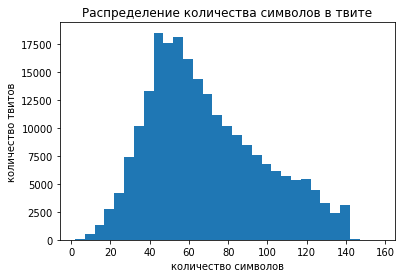

In [ ]:
create_hist(symb_len, np.arange(symb_min, symb_max, 5), 'Распределение количества символов в твите', 'количество символов', 'количество твитов')

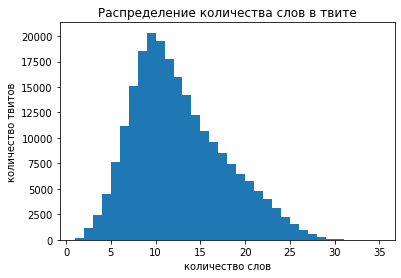

In [ ]:
create_hist(word_len, np.arange(word_min, word_max, 1), 'Распределение количества слов в твите', 'количество слов', 'количество твитов')

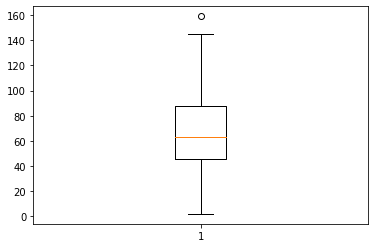

In [ ]:
create_boxplot(symb_len)

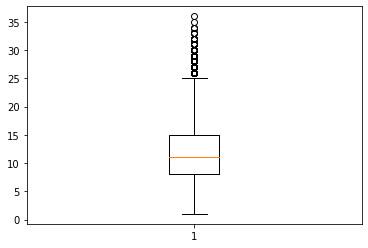

In [ ]:
create_boxplot(word_len)

In [ ]:
get_ngrams(2, twits, worst=True)

Лучшие 10 2-грамм
[(('у', 'меня'), 8289), (('я', 'не'), 4470), (('а', 'я'), 3705), (('и', 'не'), 3235), (('не', 'могу'), 2865), (('что', 'я'), 2862), (('у', 'нас'), 2324), (('не', 'знаю'), 2025), (('у', 'тебя'), 1606), (('и', 'я'), 1525)]
Худшие 10 2-грамм
[(('Лифта', 'то'), 1), (('этаж', 'Лифта'), 1), (('пятый', 'этаж'), 1), (('на', 'пятый'), 1), (('втащили', 'на'), 1), (('меня', 'втащили'), 1), (('приплатить', 'чтобы'), 1), (('Раздумываю', 'приплатить'), 1), (('работу', 'Раздумываю'), 1), (('Такси', 'везет'), 1)]


In [ ]:
get_frequent_words(' '.join(twits), top=10)

[('не', 69374),
 (')', 65535),
 ('и', 55018),
 ('(', 54483),
 ('в', 52888),
 ('я', 52612),
 ('на', 35716),
 (':(', 33682),
 ('что', 31522),
 ('а', 26712)]

# Training of the first sentiment model

Algorithm:

- creating of word2vec
- training model: one of the GBM (i.e. LightGBM, XGBoost) / SVM / ...)

## Word2Vec

In [ ]:
def tokenize(X: np.ndarray) -> List[List[str]]:
    return [el.strip().split() for el in X] 

In [ ]:
twits_tokenized = tokenize(twits)

In [ ]:
VECTOR_SIZE = 100

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences=twits_tokenized,
                                     size=VECTOR_SIZE, 
                                     window=10, min_count=1, sg=1)

In [ ]:
w2v_model.wv.most_similar('уроке', topn=10)

[('уроках', 0.8779839277267456),
 ('географии', 0.8455512523651123),
 ('перемене', 0.840225100517273),
 ('физ-ре', 0.8396453857421875),
 ('самостоятельную', 0.8381562232971191),
 ('Учитель', 0.8363189101219177),
 ('биологии', 0.8352177143096924),
 ('матем', 0.8349128365516663),
 ('укр', 0.8287764191627502),
 ('обж', 0.8268444538116455)]

In [ ]:
w2v_model.wv['улице']

array([ 0.37868282, -0.3461936 , -0.39527294,  0.15524021, -0.15521859,
       -0.47789642, -0.29967478,  0.08862143, -0.6672601 ,  1.0189778 ,
        0.6314346 , -0.1983034 ,  0.13989499,  0.3321629 ,  0.49181437,
       -0.2103866 ,  0.42957187, -0.01277212,  0.20695168, -0.1495388 ,
        0.14975066,  0.75027496,  0.324704  , -0.06900626,  0.5726902 ,
        0.6447787 ,  0.39280292,  0.06173901, -0.47403884,  0.0062482 ,
        0.16657075, -0.9465925 ,  0.25989532, -0.13866445,  0.36634824,
       -0.4100706 , -0.56737775, -0.6240521 , -0.15733676,  0.48778093,
       -0.26115605,  0.6265135 , -0.05875947,  0.09641584,  1.5054127 ,
        0.49990627,  0.51937455,  0.21791631, -0.20129858,  0.34843814,
        0.8545033 , -0.9019192 , -0.6282438 ,  0.60777456, -0.45367473,
        0.3851915 ,  0.32540357, -0.22775032, -0.01167135,  0.7138916 ,
        0.37774864,  0.5288137 ,  0.12523125, -0.22165766,  0.16960222,
       -0.54994035, -1.1232667 ,  0.627229  , -0.64692026, -0.41

## DataBuilder

Разобьем данные на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twits_tokenized, labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
def get_mean_vec(X: List[List[str]],
                  model: gensim.models.Word2Vec) -> List[np.ndarray]:
    vec_representations = []

    for sentence in X:
        vec_representation = sum(model.wv[token] for token in sentence)
        vec_representations.append(vec_representation / len(sentence)) 

    return vec_representations        

Посчитаем среднее значение векторов, входящих в твит.

In [ ]:
X_train_vectorized = get_mean_vec(X_train, w2v_model)
X_test_vectorized = get_mean_vec(X_test, w2v_model)

100%|██████████| 45367/45367 [00:02<00:00, 22454.11it/s]


## XGBoost

In [ ]:
xgboost_model = xgboost.XGBClassifier(n_estimators=200)
xgboost_model.fit(np.array(X_train_vectorized), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
file_name = '/content/gdrive/MyDrive/Project/Models/xgb_model.pickle'
# with open(file_name, "wb") as f:
#     pickle.dump(xgboost_model, f)

In [ ]:
with open(file_name, "rb") as f:
    xgboost_model = pickle.load(f)

In [ ]:
# xgboost_model.save_model("model_xgboost.json")

In [ ]:
y_pred = xgboost_model.predict(np.array(X_test_vectorized))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# 76.70% с /len(X_right_test[i]) с ! 
# 69.93% без /len(X_right_test[i])
# 77.43% с /len(X_right_test[i]) и без !
# 80.04%
# 86.12%
# 85.54%
# 86.79%
# 88.59%
# 90.26%

Accuracy: 93.05%


0.9819850197792124


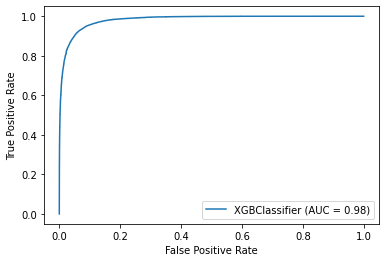

In [ ]:
y_score = xgboost_model.predict_proba(X_test_vectorized)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(xgboost_model, X_test_vectorized, y_test)  
plt.show()                               

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     22480
           1       0.93      0.94      0.93     22887

    accuracy                           0.93     45367
   macro avg       0.93      0.93      0.93     45367
weighted avg       0.93      0.93      0.93     45367



In [ ]:
conf_m = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(conf_m)

Predicted      0      1
Actual                 
0          20776   1704
1           1450  21437


## LIGHTGBM


In [ ]:
clf = lgb.LGBMClassifier(learning_rate=0.1)
clf.fit(X_train_vectorized, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred=clf.predict(X_test_vectorized)

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 0.7822
# 0.7708
# 0.8611

LightGBM Model accuracy score: 0.9013


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     22480
           1       0.91      0.90      0.90     22887

    accuracy                           0.90     45367
   macro avg       0.90      0.90      0.90     45367
weighted avg       0.90      0.90      0.90     45367



0.9650717669916892


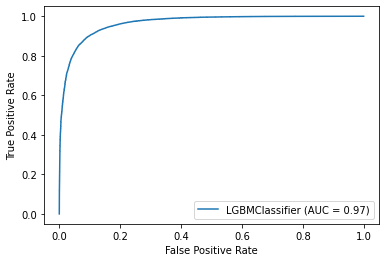

In [ ]:
y_score = clf.predict_proba(X_test_vectorized)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(clf, X_test_vectorized, y_test)  
plt.show()  

## Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=42, n_estimators = 200)
clf.fit(X_train_vectorized, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_test_vectorized)

In [ ]:
# accuracy=accuracy_score(y_pred, y_test)
print('Random forest Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Random forest Model accuracy score: 0.8189


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     22480
           1       0.82      0.83      0.82     22887

    accuracy                           0.82     45367
   macro avg       0.82      0.82      0.82     45367
weighted avg       0.82      0.82      0.82     45367



## Простая нейронная сеть

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim: int, output_dim: int = 2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

net = Net(VECTOR_SIZE)
print(net)

Net(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
X_train_net = torch.Tensor(X_train_vectorized)
y_train_net = torch.Tensor(y_train_new)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    random_index = np.random.permutation(len(X_train_net))
    X_train_net = X_train_net[random_index]
    y_train_net = y_train_net[random_index]

    for i in range(0, len(X_train_net), BATCH_SIZE): 

        batch_X = X_train_net[i:i+BATCH_SIZE]
        batch_y = y_train_net[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  3%|▎         | 1/30 [00:01<00:53,  1.85s/it]

Epoch: 0. Loss: 0.042906370013952255


  7%|▋         | 2/30 [00:03<00:50,  1.81s/it]

Epoch: 1. Loss: 0.04011097922921181


 10%|█         | 3/30 [00:05<00:47,  1.77s/it]

Epoch: 2. Loss: 0.0701151117682457


 13%|█▎        | 4/30 [00:07<00:46,  1.78s/it]

Epoch: 3. Loss: 0.03633669763803482


 17%|█▋        | 5/30 [00:08<00:44,  1.77s/it]

Epoch: 4. Loss: 0.030286595225334167


 20%|██        | 6/30 [00:10<00:42,  1.77s/it]

Epoch: 5. Loss: 0.028106985613703728


 23%|██▎       | 7/30 [00:12<00:40,  1.76s/it]

Epoch: 6. Loss: 0.005425756797194481


 27%|██▋       | 8/30 [00:14<00:38,  1.75s/it]

Epoch: 7. Loss: 0.043581992387771606


 30%|███       | 9/30 [00:16<00:37,  1.78s/it]

Epoch: 8. Loss: 0.026541633531451225


 33%|███▎      | 10/30 [00:17<00:36,  1.80s/it]

Epoch: 9. Loss: 0.03696867823600769


 37%|███▋      | 11/30 [00:19<00:34,  1.81s/it]

Epoch: 10. Loss: 0.020819436758756638


 40%|████      | 12/30 [00:21<00:32,  1.82s/it]

Epoch: 11. Loss: 0.03965351730585098


 43%|████▎     | 13/30 [00:23<00:31,  1.85s/it]

Epoch: 12. Loss: 0.037729814648628235


 47%|████▋     | 14/30 [00:25<00:30,  1.88s/it]

Epoch: 13. Loss: 0.016181737184524536


 50%|█████     | 15/30 [00:27<00:27,  1.85s/it]

Epoch: 14. Loss: 0.035336919128894806


 53%|█████▎    | 16/30 [00:28<00:25,  1.84s/it]

Epoch: 15. Loss: 0.0403812974691391


 57%|█████▋    | 17/30 [00:30<00:23,  1.83s/it]

Epoch: 16. Loss: 0.022487066686153412


 60%|██████    | 18/30 [00:32<00:21,  1.83s/it]

Epoch: 17. Loss: 0.01756962202489376


 63%|██████▎   | 19/30 [00:34<00:20,  1.88s/it]

Epoch: 18. Loss: 0.024407295510172844


 67%|██████▋   | 20/30 [00:36<00:18,  1.87s/it]

Epoch: 19. Loss: 0.01129075326025486


 70%|███████   | 21/30 [00:38<00:17,  1.90s/it]

Epoch: 20. Loss: 0.033511560410261154


 73%|███████▎  | 22/30 [00:40<00:15,  1.89s/it]

Epoch: 21. Loss: 0.015302380546927452


 77%|███████▋  | 23/30 [00:42<00:13,  1.88s/it]

Epoch: 22. Loss: 0.02193509042263031


 80%|████████  | 24/30 [00:44<00:11,  1.88s/it]

Epoch: 23. Loss: 0.01349778100848198


 83%|████████▎ | 25/30 [00:45<00:09,  1.87s/it]

Epoch: 24. Loss: 0.014044249430298805


 87%|████████▋ | 26/30 [00:47<00:07,  1.88s/it]

Epoch: 25. Loss: 0.0220512505620718


 90%|█████████ | 27/30 [00:49<00:05,  1.90s/it]

Epoch: 26. Loss: 0.0439474880695343


 93%|█████████▎| 28/30 [00:51<00:03,  1.91s/it]

Epoch: 27. Loss: 0.03237636759877205


 97%|█████████▋| 29/30 [00:53<00:01,  1.94s/it]

Epoch: 28. Loss: 0.025036823004484177


100%|██████████| 30/30 [00:55<00:00,  1.86s/it]

Epoch: 29. Loss: 0.019384413957595825


In [ ]:
file_name_nn = '/content/gdrive/MyDrive/Project/Models/simle_nn_model.pickle'
# with open(file_name_nn, "wb") as f:
#     pickle.dump(net, f)

In [ ]:
with open(file_name_nn, "rb") as f:
    net = pickle.load(f)

In [ ]:
X_test_net = torch.Tensor(X_test_vectorized)
y_test_net = torch.Tensor(y_test_new)

In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_net))):
        real_class = torch.argmax(y_test_net[i])
        net_out = net(X_test_net[i]) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
# 0.891
# 0.907
# 0.917

100%|██████████| 45367/45367 [00:04<00:00, 10457.44it/s]

Accuracy:  0.959


In [ ]:
print(classification_report(y_test,vect_y_predict))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22480
           1       0.96      0.96      0.96     22887

    accuracy                           0.96     45367
   macro avg       0.96      0.96      0.96     45367
weighted avg       0.96      0.96      0.96     45367



# Extension of word2vec

Algorithm:

- Train TF-IDF model on the normalized corpus
- TF = frequency of a word in document, IDF = log(N/#{count of documents with a word})
- word2vec.get_vector(word) * idf(word) 

In [ ]:
def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text  

In [ ]:
def compute_idf(word, corpus):
    s = sum([1.0 for i in corpus if word in i])
    if s == 0:
        return math.log10(len(corpus))
    return math.log2(len(corpus)/s)

In [ ]:
dictionary = corpora.Dictionary(X_train)
corpus = [dictionary.doc2bow(text) for text in X_train]
tfidf = models.TfidfModel(corpus)

In [ ]:
dictionary.token2id['мой']

243

In [ ]:
tfidf.idfs[dictionary.token2id['мой']]

6.444900566578848

In [ ]:
tfidf.idfs[dictionary.token2id[':)']]

3.5928307440544955

In [ ]:
#сделать функцию для test и train
X_vec_idf = []
for i in tqdm(range(len(X_train))):
    ans = 0
    for el in X_train[i]:
        ans += w2v_model.wv[el] * tfidf.idfs[dictionary.token2id[el]]
                                                    
    X_vec_idf.append(ans)

100%|██████████| 181467/181467 [00:12<00:00, 14921.28it/s]


Обучим модель

In [ ]:
model_extended_xgb = xgboost.XGBClassifier()
model_extended_xgb.fit(np.array(X_vec_idf), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
file_name_ext = '/content/gdrive/MyDrive/Project/Models/extended_xgb_model.pickle'
with open(file_name_ext, "wb") as f:
    pickle.dump(model_extended_xgb, f)

In [ ]:
with open(file_name_ext, "rb") as f:
    model_extended_xgb = pickle.load(f)

In [ ]:
X_vec_idf_test = []
for i in tqdm(range(len(X_test))):
    ans = 0
    for el in X_test[i]:
        if el in dictionary:
          idf = tfidf.idfs[dictionary.token2id[el]]
        else:
          idf = np.sqrt(len(X_train))  

        ans += w2v_model.wv[el] * idf
                                                    
    X_vec_idf_test.append(ans)

100%|██████████| 45367/45367 [00:04<00:00, 9838.64it/s] 


In [ ]:
y_pred = model_extended_xgb.predict(np.array(X_vec_idf_test))
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#61.70%
#71.20%
#75.97%
#77.24%

Accuracy: 76.37%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79     22480
           1       0.88      0.62      0.72     22887

    accuracy                           0.76     45367
   macro avg       0.79      0.77      0.76     45367
weighted avg       0.79      0.76      0.76     45367



In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

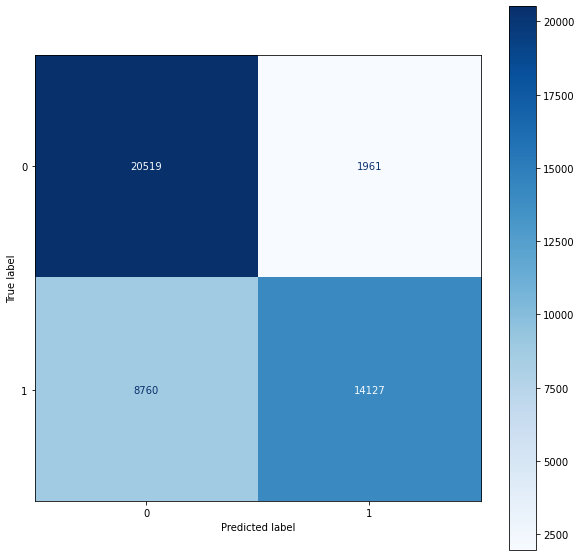

In [ ]:
plot_confusion_matrix(y_test, y_pred)

# Tacatron encoder

Теперь построим нейронную сеть, такую как encoder в Tacatron.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_size: int):
        super().__init__()
        self.embedding_size = embedding_size
        self.embed = nn.Embedding(vocab_size, embedding_size)

        self.conv1 = nn.Conv1d(36, 8, 4)
        self.conv2 = nn.Conv1d(8, 16, 4)
        self.conv3 = nn.Conv1d(16, 32, 4)

        self.lstm = nn.LSTM(23, 20, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(32 * 20 * 2, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embed(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        packed_output, (hidden, cell) = self.lstm(x)
        cat = packed_output
        rel = F.relu(cat)
        ans = rel.reshape(rel.shape[0], -1)
        dense1 = self.fc1(ans)
      
        return dense1

In [ ]:
len_pos = len(pos_text)
len_neg = len(neg_text)
twits = np.concatenate((pos_text, neg_text))
labels = [1] * len_pos + [0] * len_neg
labels = np.array(labels)

- Фиксируем длину вектора равным максимальному числу слов в твите. То есть каждому твиту сопоставляем числовой вектор такого размера.

- Строим словарь слов (как раньше), но только по твитам из Train.

- Зафиксируем 0 (ноль) – как служебный символ. Будем его использовать, когда слова нет.

- Зафиксируем 1 (единица) – как служебный символ. Будем использовать, если для слова нет кода.

- Теперь можно сделать batch_size = 32.

In [ ]:
# максимальное число слов в твите
def find_max_number(twits: List[List[str]]) -> int:
    return max(len(twit) for twit in twits)  

In [ ]:
max_len = find_max_number(twits_tokenized)
max_len

36

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_twits, labels, test_size=0.2, random_state=42)

In [ ]:
def build_dict(twits: List[List[str]], indent=2): # -> Dict[str, int]
    X_dict = {}
    for twit in twits:
        for token in twit:
            X_dict[token] = X_dict.get(token, len(X_dict) + indent)

    return X_dict

In [ ]:
vocabulary = build_dict(X_train)

In [ ]:
# кодируем слова в соответствии со словарем
def encode(X, dict_, unk_token: int = 1) -> List[List[int]]:
    X_twits_encoded = copy.deepcopy(X)

    for n_el, el in enumerate(X_twits_encoded):
        for n_i, i in enumerate(el):
            # el[n_i] = X_dict.get(i, 1)
            el[n_i] = vocabulary.get(i, 1)

    return X_twits_encoded     

In [ ]:
X_train_encoded = encode(X_train, vocabulary)
X_test_encoded = encode(X_test, vocabulary)

In [ ]:
# from torch.nn.utils.rnn import pad_sequence
# a = torch.ones(30)
# b = torch.ones(20)
# c = torch.ones(15)
# pad_sequence([a, b, c], batch_first=True, padding_value=0).size()

In [ ]:
# добавляем нули, чтобы дополнить вектор до длины = максимальному числу слов в твите
def addition(X, number_words=max_len):
    X_add = copy.deepcopy(X)
    for i, el in enumerate(X):
        cur_len = len(el)
        add_zero = number_words - cur_len
        cur_list = copy.deepcopy(el)
        cur_list += [0] * add_zero
        X_add[i] = cur_list

    return X_add     

In [ ]:
X_train_encoded = addition(X_train_encoded)
X_test_encoded = addition(X_test_encoded)

In [ ]:
len(X_test_encoded[0])

36

In [ ]:
vocab_size = len(vocabulary) + 2
embedding_size = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = Encoder(vocab_size, embedding_size).to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
y_train[:2]

array([1, 0])

In [ ]:
for epoch in tqdm(range(EPOCHS)):

    for i in range(0, len(X_train_encoded), BATCH_SIZE): 

        batch_X = torch.LongTensor(X_train_encoded[i:i+BATCH_SIZE]).view(min(BATCH_SIZE, len(X_train_encoded[i:i+BATCH_SIZE])), -1)
        batch_y = torch.LongTensor(y_train[i:i+BATCH_SIZE])

        # batch_X = pad_sequence([torch.LongTensor(a) for a in X_train_encoded[i:i+BATCH_SIZE]], batch_first=True, padding_value=0)
        # batch_y = pad_sequence([torch.LongTensor(a) for a in y_train[i:i+BATCH_SIZE]], batch_first=True, padding_value=0)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()

        outputs = net(batch_X)
        t = batch_y
        loss = loss_function(outputs, t)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

 10%|█         | 1/10 [00:19<02:51, 19.00s/it]

Epoch: 0. Loss: 0.07658164948225021


 20%|██        | 2/10 [00:37<02:30, 18.86s/it]

Epoch: 1. Loss: 0.053099680691957474


 30%|███       | 3/10 [00:56<02:11, 18.84s/it]

Epoch: 2. Loss: 0.036094918847084045


 40%|████      | 4/10 [01:15<01:52, 18.76s/it]

Epoch: 3. Loss: 0.0012315807398408651


 50%|█████     | 5/10 [01:33<01:33, 18.77s/it]

Epoch: 4. Loss: 0.0012065015034750104


 60%|██████    | 6/10 [01:52<01:15, 18.77s/it]

Epoch: 5. Loss: 0.016753293573856354


 70%|███████   | 7/10 [02:11<00:56, 18.74s/it]

Epoch: 6. Loss: 0.061529140919446945


 80%|████████  | 8/10 [02:30<00:37, 18.76s/it]

Epoch: 7. Loss: 0.011863750405609608


 90%|█████████ | 9/10 [02:48<00:18, 18.72s/it]

Epoch: 8. Loss: 0.006533307023346424


100%|██████████| 10/10 [03:07<00:00, 18.77s/it]

Epoch: 9. Loss: 0.0007001767517067492


In [ ]:
file_name_nn = '/content/gdrive/MyDrive/Project/Models/tacatron_encoder_model.pickle'
# with open(file_name_nn, "wb") as f:
#     pickle.dump(net, f)

In [ ]:
with open(file_name_nn, "rb") as f:
    net = pickle.load(f)

RuntimeError: ignored

In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_encoded))):

        batch_X = torch.LongTensor(X_test_encoded[i]).view(1, -1)
        batch_y = torch.LongTensor(y_test[i])
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net_out = net(batch_X) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())

        if predicted_class == y_test[i]:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))
#0.919
#0.966

  0%|          | 0/45367 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:680: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|██████████| 45367/45367 [01:07<00:00, 667.21it/s]

Accuracy:  0.966


In [ ]:
print(classification_report(y_test, vect_y_predict))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     22480
           1       0.94      0.99      0.97     22887

    accuracy                           0.97     45367
   macro avg       0.97      0.97      0.97     45367
weighted avg       0.97      0.97      0.97     45367



# Compare quality of several models

Launch our algorithms (5-10 times) on the test sample.

Calculate all previous metrics and stores their results to make statistical analysis:
- confidence interval (95%-97%)
- hypothesis analysis (null hypothesis - quality of models are the same, alternative - quality is changed), T-test

In [ ]:
def find_metrics(y_true, y_pred):

    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2*TP/(2*TP + FP + FN)  

    return precision, recall, f1_score

In [ ]:
def find_mean_metrics(method, number_iterations):
    precision_mean, recall_mean, f1_score_mean = 0, 0, 0
    cur_metrics = []

    for i in tqdm(range(number_iterations)):
      precision, recall, f1_score = method
      cur_metrics.append((precision, recall, f1_score))
      precision_mean += precision
      recall_mean += recall
      f1_score_mean += f1_score

    precision_mean /= number_iterations
    recall_mean /= number_iterations
    f1_score_mean /= number_iterations  

    return cur_metrics, precision_mean, recall_mean, f1_score_mean

In [ ]:
def write_file(name, cur_metrics, precision_mean, recall_mean, f1_score_mean):

    #запишем промежуточные и конечные результаты в файл
    f = open(name, 'w')
    f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
    for i in cur_metrics:
        f.write(str(i) + '\n')

    f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
    f.write(str(precision_mean) + str(recall_mean) +  str(f1_score_mean))
    f.close()


In [ ]:
def XGBoost_train():
    X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

    #X_train list; здесь токенизируем
    X_right = tokenize(X_train)
    model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)    

    # посчитаем среднее значение векторов, входящих в твит
    X_vec = find_mean_vec(X_right, model_right)  

    model = xgboost.XGBClassifier(n_estimators=200)
    model.fit(np.array(X_vec), y_train)

    #X_test in list
    X_right_test = tokenize(X_test)

    model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)
    model_right.build_vocab(X_right_test, update=True)   


    X_vec_test = find_mean_vec(X_right_test, model_right)
    y_pred = model.predict(np.array(X_vec_test))

    precision, recall, f1_score = find_metrics(y_test, y_pred) 

    return precision, recall, f1_score

In [ ]:
find_mean_metrics(XGBoost_train(), 1)


100%|██████████| 1/1 [00:00<00:00, 7423.55it/s]


([(0.9262968155417585, 0.8083191331323458, 0.8632959238433001)],
 0.9262968155417585,
 0.8083191331323458,
 0.8632959238433001)

In [ ]:
# number_iterations = 5
# cur_metrics, precision_mean, recall_mean, f1_score_mean = find_mean_metrics(XGBoost_train(), number_iterations)

In [ ]:
#write_file('xgboost_results.txt', cur_metrics, precision_mean, recall_mean, f1_score_mean)

In [ ]:
precision_mean, recall_mean, f1_score_mean = 0, 0, 0
number_iterations = 5
cur_metrics = []

for i in tqdm(range(number_iterations)):
  precision, recall, f1_score = XGBoost_train()
  cur_metrics.append((precision, recall, f1_score))
  precision_mean += precision
  recall_mean += recall
  f1_score_mean += f1_score

precision_mean /= number_iterations
recall_mean /= number_iterations
f1_score_mean /= number_iterations


100%|██████████| 5/5 [39:41<00:00, 476.33s/it]


In [ ]:
#запишем промежуточные и конечные результаты в файл
f = open('xgboost_results.txt', 'w')
f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
for i in cur_metrics:
    f.write(str(i) + '\n')

f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
f.write(str(precision_mean) + str(recall_mean) +  str(f1_score_mean))
f.close()

In [ ]:
print(precision_mean, recall_mean, f1_score_mean)

0.9349607161461948 0.8103901778302092 0.8677674368640979


In [ ]:
def Simple_nn():  

    X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

    y_train_new = [np.eye(2)[i] for i in y_train]
    y_test_new = [np.eye(2)[i] for i in y_test]

    X_right = tokenize(X_train)   

    model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)    


    X_vec = find_mean_vec(X_right, model_right)   

    X_train_net = torch.Tensor(X_vec)
    y_train_net = torch.Tensor(y_train_new)  

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()  

    BATCH_SIZE = 128
    EPOCHS = 30

    for epoch in tqdm(range(EPOCHS)):

        random_index = np.random.permutation(len(X_train_net))
        X_train_net = X_train_net[random_index]
        y_train_net = y_train_net[random_index]

        for i in range(0, len(X_train_net), BATCH_SIZE): 

            batch_X = X_train_net[i:i+BATCH_SIZE]
            batch_y = y_train_net[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    


    X_right_test = tokenize(X_test)


    model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)
    model_right.build_vocab(X_right_test, update=True)   


    X_vec_test = find_mean_vec(X_right_test, model_right)

    X_test_net = torch.Tensor(X_vec_test)
    y_test_net = torch.Tensor(y_test_new)    


    correct = 0
    total = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for i in tqdm(range(len(X_test_net))):
            real_class = torch.argmax(y_test_net[i])
            y_test.append(real_class)
            net_out = net(X_test_net[i]) 
            predicted_class = torch.argmax(net_out)
            y_pred.append(predicted_class)
    
    precision, recall, f1_score = find_metrics(y_test, y_pred) 

    return precision, recall, f1_score

In [ ]:
precision_mean, recall_mean, f1_score_mean = 0, 0, 0
number_iterations = 5
cur_metrics = []
for i in tqdm(range(number_iterations)):
  precision, recall, f1_score = Simple_nn()
  cur_metrics.append((precision, recall, f1_score))
  precision_mean += precision
  recall_mean += recall
  f1_score_mean += f1_score

precision_mean /= number_iterations
recall_mean /= number_iterations
f1_score_mean /= number_iterations

In [ ]:
f = open('simple_nn_results.txt', 'w')
f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
for i in cur_metrics:
    f.write(str(i) + '\n')

f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
f.write(str(precision_mean) + ' ' + str(recall_mean) + ' ' +  str(f1_score_mean))
f.close()    

In [ ]:
#cur_metrics, precision_mean, recall_mean, f1_score_mean = find_mean_metrics(Simple_nn(), 5)

In [ ]:
#write_file('simple_nn_results.txt', cur_metrics, precision_mean, recall_mean, f1_score_mean)

In [ ]:
print(precision_mean, recall_mean, f1_score_mean)

Теперь сравним 2 модели. XGBoost и простую нейронную сеть.

In [ ]:
stats.ttest_ind(rvs1,rvs2)

# Create a simple sentiment annotator for named entities

- Chose dataset with NE: Person, Organization, ... 
(https://tatianashavrina.github.io/2018/08/30/datasets/#ner);
- Apply two of the our best models for NE's context (N = 5-7 words from the left + 5-7 words from the right);
Each best model for each student :) One model should be a simple, another model - a neural;

Note: try to design an architecture prototype of our annotator!

Hints: main classes (Annotator(Model model), Model (abstract class)), Handler

In [ ]:
# networks, xgboost

In [ ]:
from abc import ABC, abstractmethod

In [ ]:
from collections import namedtuple

annotation = namedtuple('annotation', 'tag, start, end, ne')

In [ ]:
class Dataset:
    def __init__(self):
        self.dataset = [] # храним набор tuple (text, [(annotation, start, end, ne)])
        self.crop_sentences = []
   
    def load_sentences(self, ann_file_path: str, text_file_path: str):
        with open(text_file_path, 'r') as text_file:
            text = text_file.read()

        with open(ann_file_path, 'r') as ann_file:
            annotations = []
            for line in ann_file.readlines():
                tokens = line.split()
                annotations.append(annotation(tokens[1], tokens[2], tokens[3], tokens[4]))

        cur_tuple = (text, annotations)
        self.dataset.append(cur_tuple)

    def _get_left(self, local_text: str, ann: annotation) -> List[str]:
        pos = int(ann.start) - 1
        cur_word = ''
        words = []

        while pos >= 0 and len(words) < window_size:
            if local_text[pos] == ' ':
                if cur_word != '':
                    words.append(cur_word[::-1])
                cur_word = ''
            else:
                cur_word += local_text[pos]
            pos -= 1

        if cur_word != '':
            words.append(cur_word[::-1])

        return words[::-1]  

    def _get_right(self, local_text: str, ann: annotation) -> List[str]:
        pos_right = int(ann.end)
        cur_word = ''
        words_right = []

        while pos_right < len(local_text) and len(words_right) < window_size:
            if local_text[pos_right] == ' ':
                if cur_word != '':
                    words_right.append(cur_word)
                cur_word = ''    
            else:
                cur_word += local_text[pos_right]  

            pos_right += 1 

        if cur_word != '':
            words_right.append(cur_word) 
        
        return words_right
      

    def build_crop_sentences(self, window_size: int):
        for text, annotators in self.dataset:
            local_text = text.replace('\n', '  ')
            local_text = local_text.replace('\r', '  ')
            local_text = local_text.replace('\t', '  ')

            for ann in annotators:
                left = self._get_left(local_text, ann)
                right = self._get_right(local_text, ann)       

                self.crop_sentences.append((ann, ' '.join(left), ' '.join(right)))

In [ ]:
class Model(ABC):
    def __init__(self, model, w2v):
        self.model = model
        self.w2v = w2v

    @abstractmethod
    def __call__(self, s: str) -> float:
        pass

In [ ]:
class XGBoostModel(Model):
    def __init__(self, model, w2v):
        super().__init__(model, w2v)

    def __call__(self, s: str):
        # self.model.predict(x)
        pass

In [ ]:
class NetModel(Model):
    def __init__(self, model, w2v):
        super().__init__(model, w2v)
        
    def __call__(self, s: str) -> float:
        s_tokenized = tokenize(s)
        self.w2v.build_vocab(s_tokenized, update=True)
        self.w2v.train(s_tokenized, total_examples = len(s_tokenized),
                       epochs = 10)
        s_vectorized = get_mean_vec(s_tokenized, self.w2v)
        X_tensor_net = torch.Tensor(s_vectorized)
        net_out = self.model(X_tensor_net[0]) 
        return net_out[1].item()

In [ ]:
class Annotator:
    def __init__(self, model: Model):
        self.model = model

    def annotate(self, dataset: Dataset, window_size: int):
        data = []
        dataset.build_crop_sentences(window_size)

        for crop_sentence in tqdm(dataset.crop_sentences):
            s = [crop_sentence[1] + ' ' + crop_sentence[0].ne + ' ' + crop_sentence[2]]
            pos_prob = self.model(s)
            data.append((crop_sentence[1], crop_sentence[0].ne, crop_sentence[2], pos_prob))
        self.data = data

In [ ]:
dataset = Dataset()

In [ ]:
with open("/content/gdrive/MyDrive/Project/data.pickle", 'rb') as f:
    dataset.dataset = pickle.load(f)

In [ ]:
# dataset_path = "/content/gdrive/MyDrive/Project/Collection5"
# a = os.listdir(dataset_path)
# a.sort()

# for i in tqdm(range(0, len(a) - 1, 2), position=0, leave=True):
#     ann_path = dataset_path + '/' + a[i]
#     text_path = dataset_path + '/' + a[i + 1]
#     dataset.load_sentences(ann_path, text_path)

# with open("/content/gdrive/MyDrive/Project/data.pickle", 'wb') as f:
#     pickle.dump(dataset.dataset, f)

100%|██████████| 3/3 [00:00<00:00, 304.27it/s]


In [ ]:
net_model = NetModel(net, w2v_model)
annotator = Annotator(net_model)

In [ ]:
annotator.annotate(dataset, 5)

In [ ]:
annotator.data[:5]

[('',
  'Россия',
  'рассчитывает на конструктивное воздействие США',
  0.9984500408172607),
 ('Россия рассчитывает на конструктивное воздействие',
  'США',
  'на Грузию 04/08/2008 12:08 МОСКВА,',
  0.9966751337051392),
 ('на конструктивное воздействие США на',
  'Грузию',
  '04/08/2008 12:08 МОСКВА, 4 авг',
  0.9998002648353577),
 ('США на Грузию 04/08/2008 12:08',
  'МОСКВА',
  ', 4 авг - РИА',
  0.9999957084655762),
 ('12:08 МОСКВА, 4 авг -',
  'РИА',
  '. Россия рассчитывает, что США',
  0.9813258647918701)]